# Download Data from Earth Access

* You must have an earthdata account. An account is free to sign up for.
* Before downloading, you will be given an estimate of the number of results
  and an estimate of the total disk space required. You will be prompted if you
  wish to continue to download.
* The `data_dir` parameter specifies where to save the data. If you are using
  Git or some other VCS, consider adding this value to your `.gitignore` file or
  equivalent.
* If your data directory is already populated, this step is skipped.

In [1]:
import os
from pathlib import Path
from pprint import pprint

import earthaccess

/home/kyle/projects/aerichor/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Query Parameters

* Query parameters for earthdata are described [here](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html).
* The default query selects satellite passes that contain the NCSU campus.

In [2]:
data_dir = Path("../data/spexone")
query=dict(
    short_name="PACE_SPEXONE_L2_AER_RTAPLAND",
    version="3.0",
    point=(-78.67, 35.75) 
)

In [3]:
if os.path.isdir(data_dir):
    print(f"{data_dir} exists. Skipping earthaccess query and download.")
    results=None
else:
    earthaccess.login()
    results = earthaccess.search_data(**query)
    size = sum([r['size'] for r in results])
    print(len(results), f"results were found that matched the following query: ")
    pprint(query)
    print(f"Total size of data is {size:.2f} MB.")

../data/spexone exists. Skipping earthaccess query and download.


In [4]:
if results:
    proceed = input("Proceed? y[n]") or "n"
    if proceed.lower() == "y" or proceed.lower() == "yes":
        earthaccess.download(results,data_dir)

# Load the Data

In [5]:
from aerichor.satellite.pace import SpexOne
files=[Path(data_dir) / file for file in os.listdir(data_dir)]
passes=[SpexOne.from_netcdf(file) for file in files]
sat_case=passes[0]

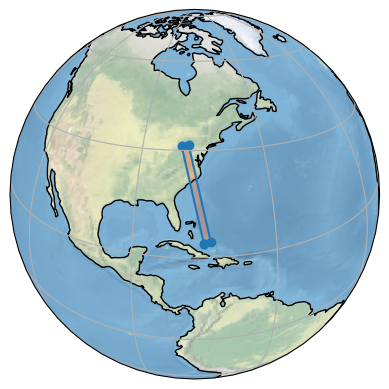

In [6]:
sat_case.show_swath()


In [ ]:
# TODO: Explain what this is - an xarray object with some custom shenanigans
sat_case

# Data Profile for Satellite Data

# Fetch Data from AQS

* You must have a (free) AQS account. You can initiate the signup proces from
  the API, but you must validate your email address.

In [8]:
from aerichor.ground.aqs import AqsClient, AqiPollutant

In [9]:
api=AqsClient.from_netrc()
pm25=api.get_pollutant_in_swath(AqiPollutant.PM25, sat_case)

## Investigate Anomalies; Clean Data

In [10]:
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [11]:
pm25.head()

,site_id,longitude,latitude,time,measurement
0,0002,-75.556818,38.986681,2024-03-24 05:00:00,NaN
1,0002,-75.556818,38.986681,2024-03-24 06:00:00,NaN
2,0002,-75.556818,38.986681,2024-03-24 07:00:00,NaN
3,0002,-75.556818,38.986681,2024-03-24 08:00:00,NaN
4,0002,-75.556818,38.986681,2024-03-24 09:00:00,NaN


In [12]:
pm25.describe()

,longitude,latitude,time,measurement
count,3179.000000,3179.000000,3179,2950.000000
mean,-77.215721,38.275312,2024-03-24 16:27:36.747404800,3.634136
min,-80.316442,25.794222,2024-03-24 05:00:00,-6.000000
25%,-79.003050,37.590880,2024-03-24 10:00:00,2.800000
50%,-76.958072,39.739441,2024-03-24 16:00:00,3.400000
75%,-75.432500,40.304694,2024-03-24 22:00:00,4.600000
max,-73.927690,40.924580,2024-03-25 04:00:00,21.700000
std,2.031933,3.542985,NaN,1.979025


Things to note:

* There are several missing values.
* There are negative $PM_{2.5}$ measurements when they should all be non-negative.

In [13]:
pm25.info()

<class 'aerichor.ground.base.GroundSampleDataFrame'>
RangeIndex: 3179 entries, 0 to 3178
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   site_id      3179 non-null   object        
 1   longitude    3179 non-null   float64       
 2   latitude     3179 non-null   float64       
 3   time         3179 non-null   datetime64[ns]
 4   measurement  2950 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 124.3+ KB


In [14]:
def plot_with_geography(data, swath, title=None):
    if not title:
        title=f"{data.label} in {data.units}"
    fig = plt.figure()
    ax = plt.subplot(111, projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_extent(swath.bbox.to_extent(buffer=2)) 
    ax.add_feature(cfeature.STATES)
    myplot=ax.scatter("longitude", "latitude", c="measurement", data=data)
    ax.set_title(title)
    fig.colorbar(myplot, extend="max")

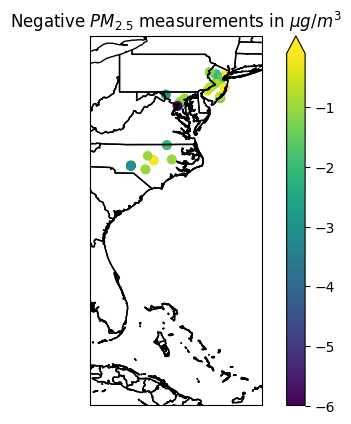

In [15]:
plot_with_geography(pm25[pm25['measurement']<0], sat_case, title=r"Negative $PM_{2.5}$ measurements in $\mu g / m^3$")

In [16]:
pm25[pm25['measurement'] < 0].describe()

,longitude,latitude,time,measurement
count,81.000000,81.000000,81,81.000000
mean,-76.279886,38.864130,2024-03-24 14:44:26.666666752,-1.556790
min,-79.836636,35.041416,2024-03-24 05:00:00,-6.000000
25%,-77.360126,38.894770,2024-03-24 09:00:00,-2.000000
50%,-76.878333,39.363260,2024-03-24 14:00:00,-1.000000
75%,-74.448736,40.222411,2024-03-24 20:00:00,-0.800000
max,-74.036218,40.924580,2024-03-25 04:00:00,-0.100000
std,1.813013,1.850926,NaN,1.287433


In [17]:
pm25_clean = pm25[pm25['measurement'] >= 0].dropna()

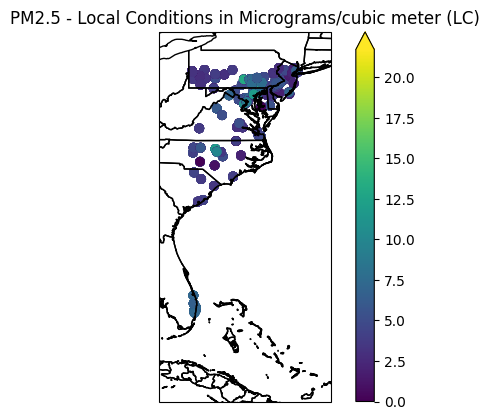

In [18]:
plot_with_geography(pm25_clean, sat_case)

Note that the sensors in Florida (as an obvious example) are outside of the
swath that we originally showed. That's because we got sensor data from the API
by using a grid-aligned bounding box that contains the swath. Those Florida
sensors are within the most extreme latitude and longitude values of the swath.
Later, we get all the satellite data that is spatially near a sensor.

## Temporally Align $PM_{2.5}$ Data with Satellite Data

The `align_temporally()` method chooses all observations in a data set that are closest (by absolute difference) to the specified time. The resulting data set has a single observation per sensor in the input data set.

In [19]:
aligned = pm25_clean.align_temporally(sat_case.start)
aligned

,site_id,longitude,latitude,time,measurement,delta_t
615,0001,-74.806671,40.515262,2024-03-24 18:00:00,4.0,0 days 00:15:46
446,0002,-75.797317,39.305021,2024-03-24 18:00:00,3.0,0 days 00:15:46
61,0003,-75.518210,39.155640,2024-03-24 18:00:00,3.8,0 days 00:15:46
1676,0004,-75.432500,40.611944,2024-03-24 18:00:00,3.3,0 days 00:15:46
639,0005,-74.742613,40.283092,2024-03-24 18:00:00,0.0,0 days 00:15:46
...,...,...,...,...,...,...
470,3001,-77.106876,39.114313,2024-03-24 18:00:00,1.0,0 days 00:15:46
1216,3007,-79.885331,40.294341,2024-03-24 18:00:00,2.7,0 days 00:15:46
302,5005,-80.176389,26.294167,2024-03-24 18:00:00,6.1,0 days 00:15:46
2662,5200,-80.243995,40.268963,2024-03-24 18:00:00,2.8,0 days 00:15:46


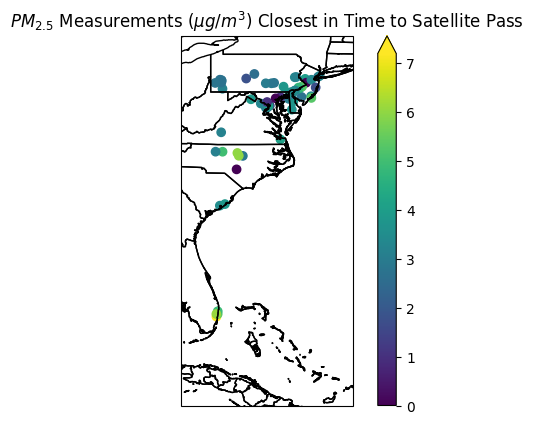

In [20]:
plot_with_geography(aligned, sat_case, title=r"$PM_{2.5}$ Measurements $(\mu g / m^3)$ Closest in Time to Satellite Pass")

## Flatten Xarray to DataFrame

Here, I flatten the latitude and longitude. Doing that, I run into problems with the contourf plot later, but it makes the data wrangling easier.

In [ ]:
# TODO: This is unexpected, so it needs to be explained
df=sat_case['geophysical_data/aot550']
df.rename(columns={'geophysical_data/aot550': 'aot'}, inplace=True)
df

,latitude,longitude,aot
0,22.760002,-75.299637,NaN
1,22.770235,-75.250214,NaN
2,22.780453,-75.200790,NaN
3,22.790653,-75.151352,NaN
4,22.800840,-75.101913,NaN
...,...,...,...
11450,41.071041,-78.886505,NaN
11451,41.081749,-78.826271,NaN
11452,41.092430,-78.766014,NaN
11453,41.103077,-78.705734,NaN


In [24]:
aotdf = df[df['aot'].notnull()]
aotdf

,latitude,longitude,aot
7257,34.305866,-77.914413,0.058702
7258,34.316654,-77.859436,0.053306
7259,34.327419,-77.804443,0.063261
7260,34.338158,-77.749443,0.064218
7286,34.351749,-77.927505,0.058300
...,...,...,...
11444,41.006119,-79.247513,0.047516
11445,41.017017,-79.187401,0.051405
11446,41.027885,-79.127258,0.049381
11447,41.038719,-79.067101,0.059815


## Join Satellite AOT to Ground-based $PM_{2.5}$

In [25]:
aligned['aot']=aligned.get_spatial_value(aotdf, "aot")
final=aligned[aligned['aot'].notnull()]

In [26]:
final

,site_id,longitude,latitude,time,measurement,delta_t,aot
1143,0008,-79.960757,40.465420,2024-03-24 18:00:00,2.7,0 days 00:15:46,0.044434
1071,0014,-78.574167,35.856111,2024-03-24 18:00:00,2.9,0 days 00:15:46,0.037446
1168,0064,-79.868062,40.323768,2024-03-24 18:00:00,2.6,0 days 00:15:46,0.042175
2998,0524,-79.805499,39.917663,2024-03-24 18:00:00,3.2,0 days 00:15:46,0.047477
1192,1301,-79.860973,40.402328,2024-03-24 18:00:00,2.9,0 days 00:15:46,0.042818
2806,1376,-79.863572,40.437430,2024-03-24 18:00:00,2.7,0 days 00:15:46,0.043924
1216,3007,-79.885331,40.294341,2024-03-24 18:00:00,2.7,0 days 00:15:46,0.041488


### Why are there so few data points?

Well, we'd expect a lot of the sensors to be thrown away because they are outside of the swath. The narrower and more angled the swath is relative to the grid, the higher proportion of sensors thrown away. See the appendix. 

There's also missing data within swaths. Need to be able to estimate that - quantitatively and/or via plot. These are satellite data that have measurements within 0.25 lat/lon of a sensor.

# Loop over satellite data to build a data set

Let's try to add info so we can audit any weird data points that we see.

In [28]:
# Initialize accumulator DataFrame
#api=AqsClient.from_netrc()
dataframes = []
for swath in passes[0:3]:
    pm25=api.get_pollutant_in_swath(AqiPollutant.PM25, sat_case)
    pm25.dropna(inplace=True)
    cleaned=pm25[pm25['measurement'] >= 0].dropna()
    aligned=cleaned.align_temporally(swath.start)
    # Flatten satellite dataframe
    flat=swath['geophysical_data/aot550'].rename(columns={'geophysical_data/aot550':'aot'})
    aligned['aot']=aligned.get_spatial_value(flat, 'aot')
    final=aligned[aligned['aot'].notnull()]
    # Append to Accumulating dataframe
    dataframes.append(final)

In [29]:
import pandas as pd
main = pd.concat(dataframes,ignore_index=True)

In [30]:
main

,site_id,longitude,latitude,time,measurement,delta_t,aot
0,0008,-79.960757,40.465420,2024-03-24 18:00:00,2.7,0 days 00:15:46,0.044434
1,0014,-78.574167,35.856111,2024-03-24 18:00:00,2.9,0 days 00:15:46,0.037446
2,0064,-79.868062,40.323768,2024-03-24 18:00:00,2.6,0 days 00:15:46,0.042175
3,0524,-79.805499,39.917663,2024-03-24 18:00:00,3.2,0 days 00:15:46,0.047477
4,1301,-79.860973,40.402328,2024-03-24 18:00:00,2.9,0 days 00:15:46,0.042818
5,1376,-79.863572,40.437430,2024-03-24 18:00:00,2.7,0 days 00:15:46,0.043924
6,3007,-79.885331,40.294341,2024-03-24 18:00:00,2.7,0 days 00:15:46,0.041488
7,0013,-79.802314,36.109006,2024-03-25 04:00:00,6.0,115 days 13:50:12,0.136725
8,0013,-79.802314,36.109006,2024-03-25 04:00:00,6.0,98 days 13:51:12,0.117497
9,0015,-78.904037,36.032955,2024-03-25 04:00:00,12.0,98 days 13:51:12,0.079318


# Model and Plot

In [45]:
import sklearn
reg = sklearn.linear_model.LinearRegression()
reg.fit(main['aot'].to_frame(), main['measurement'])
print(reg.coef_)
print(reg.intercept_)

[35.76252001]
2.20538923431503


In [ ]:
predicted=reg.predict(main['aot'].to_frame())
r2=sklearn.metrics.r2_score(main['measurement'], predicted)
r2

0.24835918813196234

(0.0, 12.47)

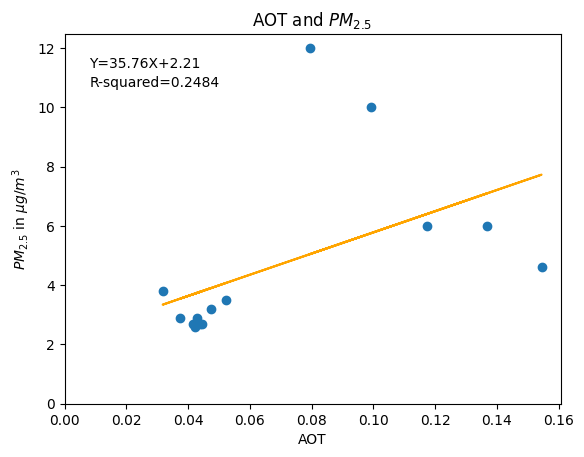

In [65]:
fig = plt.figure()
ax = plt.subplot(111)
ax.scatter(main['aot'], main['measurement'])
ax.plot(main['aot'], predicted, color="orange")
ax.set_title(r"AOT and $PM_{2.5}$ ")
ax.set_xlabel(r"AOT")
ax.set_ylabel(r"$PM_{2.5}$ in $\mu g / m^3$")
ax.text(
    0.05,0.9,
    f"Y={reg.coef_[0]:2.2f}X+{reg.intercept_:2.2f}",
    verticalalignment="bottom",
    horizontalalignment="left",
    transform=ax.transAxes,
    )
ax.text(
    0.05,0.85,
    f"R-squared={r2:.4f}",
    verticalalignment="bottom",
    horizontalalignment="left",
    transform=ax.transAxes,
)
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)

# Appendix: Satellite Data that is near Sensors

This is where flattening the latitude and longitude of the satelite data becomes
a problem. To plot over an area, you should use the `contourf` plot. But that
expects 2-D arrays for input. Since we flattened latitude and longitude, the `contourf` plotting function doesn't work. I made a scatterplot, which kinda works - it still displays latitude x longitude x measurment. But it looks gross with overlapping markers.

The `contourf` examples that go from 1-D arrays to 2-D arrays tend to use `np.meshgrid()`. Hmm... That might work. Originally, I'd thought that wouldn't work because we don't have an even grid. By that, I mean we don't have a measurement for each point on the latitude, longitude lattice that `meshgrid()` would create. But so what? We'll just have a lot of zeros.

In [ ]:
# "near" is defined by data that is within +/- 0.25 degrees of lat/lon of a sensor
from functools import partial
def is_near_points(row, buffer=0.25, points_df=None):
    lat=abs(points_df['latitude'] - row['latitude']) < buffer
    lon=abs(points_df['longitude']- row['longitude']) < buffer
    return (lat & lon).any()

# Is there a way to hide "partial" from end users?
is_near_sensor=partial(is_near_points, points_df=pm25)

In [36]:
row={'latitude':34.5, 'longitude':-77.9}
is_near_points(row, points_df=pm25)

np.True_

In [37]:
aotdf.apply(is_near_sensor,axis=1)

7257      True
7258      True
7259      True
7260      True
7286      True
         ...  
11444    False
11445    False
11446    False
11447    False
11448    False
Length: 2484, dtype: bool

In [38]:
near=aotdf[aotdf.apply(is_near_sensor,axis=1)]

In [39]:
near

,latitude,longitude,aot
7257,34.305866,-77.914413,0.058702
7258,34.316654,-77.859436,0.053306
7259,34.327419,-77.804443,0.063261
7260,34.338158,-77.749443,0.064218
7286,34.351749,-77.927505,0.058300
...,...,...,...
11438,40.940075,-79.607811,0.048118
11439,40.951160,-79.547813,0.052554
11440,40.962215,-79.487793,0.053208
11441,40.973236,-79.427750,0.050758


In [40]:
def plot2_with_geography(data, swath):
    fig = plt.figure()
    ax = plt.subplot(111, projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_extent(swath.bbox.to_extent(buffer=2)) 
    ax.add_feature(cfeature.STATES)
    # This is where to define a class-based plot
    # contourf expects z to be 2d
    #myplot=ax.contour(data['longitude'], data['latitude'], data['aot'])
    myplot=ax.scatter(data['longitude'], data['latitude'], c=data['aot'])
    ax.set_title(f"AOD on {swath.start.date()}")
    fig.colorbar(myplot, extend="max")

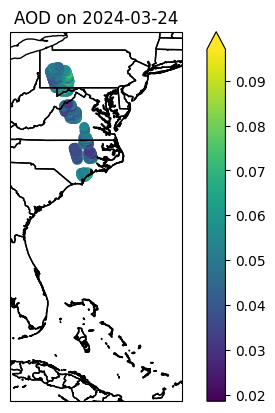

In [41]:
plot2_with_geography(near, sat_case)

Note now that the plotted data resides entirely within the swath.